# qiskit-ibm-provider, the "new" IBM Quantum provider

### Qiskit Demo Day (May 12, 2022)

### Rathish Cholarajan

### Installation

```
pip install qiskit-ibm-provider
```

Note: This package has to be installed separately and will not get installed as part of qiskit meta package.

### Load Account using Saved Credentials

#### Before

In [ ]:
from qiskit import IBMQ

IBMQ.save_account(token='MY_API_TOKEN')
provider = IBMQ.load_account() # loads saved account from disk

#### After

In [ ]:
from qiskit_ibm_provider import IBMProvider

IBMProvider.save_account(token='MY_API_TOKEN')
provider = IBMProvider() # loads default saved account from disk

IBMProvider.save_account(token='MY_API_TOKEN_2', name="personal")
provider = IBMProvider(name="personal") # loads saved account from disk named "personal"

### Saved Account

#### Before

In [ ]:
from qiskit import IBMQ

IBMQ.stored_account() # get saved account from qiskitrc file

#### After

In [17]:
from qiskit_ibm_provider import IBMProvider

IBMProvider.saved_accounts() # get saved accounts from qiskit-ibm.json file

{'default-ibm-quantum': {'channel': 'ibm_quantum',
  'token': 'xyzabc',
  'url': 'https://auth.quantum-computing.ibm.com/api',
  'instance': 'ibm-q/open/main',
  'verify': True}}

### Load Account using Environment Variables

#### Before

In [ ]:
# export QE_TOKEN='MY_API_TOKEN' (bash command)

from qiskit import IBMQ

provider = IBMQ.load_account() # loads account from env variables

#### After

In [ ]:
# export QISKIT_IBM_TOKEN='MY_API_TOKEN' (bash command)

from qiskit_ibm_provider import IBMProvider

provider = IBMProvider() # loads account from env variables

### Enable Account

#### Before

In [ ]:
from qiskit import IBMQ

provider = IBMQ.enable_account(token='MY_API_TOKEN') # enable account for current session

#### After

In [ ]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(token='MY_API_TOKEN') # enable account for current session

### hub/group/project selection order

It is now optional to specify a hub/group/project upfront when connecting to the IBM Quantum account. The hub/group/project is selected in the following order (decreasing order of priority).

- hub/group/project if passed via `instance` parameter when calling `provider.get_backend(<backend_name>, instance="h/g/p")`

- hub/group/project if passed via `instance` parameter when initializing `IBMProvider(..., instance="h/g/p)"`

- the default set previously via `save_account(..., instance="h/g/p")`

- a premium hub/group/project in your account

- open access hub/group/project

### Active Account

#### Before

In [ ]:
from qiskit import IBMQ
provider = IBMQ.load_account() # load saved account

IBMQ.active_account() # check active account

#### After

In [18]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider() # load saved account

provider.active_account() # check active account

{'channel': 'ibm_quantum',
 'token': 'xyzabc',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'instance': 'ibm-q/open/main',
 'verify': True}

### Delete Account

#### Before

In [ ]:
from qiskit import IBMQ

IBMQ.delete_account() # delete saved account from qiskitrc file

#### After

In [ ]:
from qiskit_ibm_provider import IBMProvider

IBMProvider.delete_account() # delete saved account from saved credentials

### Retrieve backends

In [15]:
provider.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_armonk')>,
 <IBMBackend('ibmq_santiago')>,
 <IBMBackend('ibmq_bogota')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>]

### Get backend

In [19]:
backend = provider.get_backend("ibmq_manila")
print(backend)

<IBMBackend('ibmq_manila')>


### BackendV2

Flatter access patterns:
```python
# BackendV1:
backend.configuration().n_qubits

# BackendV2:
backend.num_qubits
```

Only breaking change: `backend.name` is no longer a method but a property in BackendV2.

### Run Circuits

In [20]:
from qiskit import QuantumCircuit

# Bell state circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

In [23]:
from qiskit import transpile
qc = transpile(qc, backend)

job = backend.run(circuits=qc, shots=1024)
result = job.result()
print(result)

Result(backend_name='ibmq_manila', backend_version='1.0.29', qobj_id='6ea6a83d-bf62-48df-a2a8-98627b0921e5', job_id='627c7cb57c918115bb9a73fe', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 517, '0x1': 20, '0x2': 44, '0x3': 443}), header=QobjExperimentHeader(qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]], n_qubits=5, qreg_sizes=[['q', 5]], clbit_labels=[['meas', 0], ['meas', 1]], memory_slots=2, creg_sizes=[['meas', 2]], name='circuit-0', global_phase=0.7853981633974483, metadata={}))], date=2022-05-11 23:26:49-04:00, status=Successful completion, status=QobjHeader(backend_name='ibmq_manila', backend_version='1.0.29'), execution_id='58f5de74-d1a3-11ec-b806-bc97e15b08d0', time_taken=5.193728923797607, error=None, client_version={'qiskit': '0.35.0'})


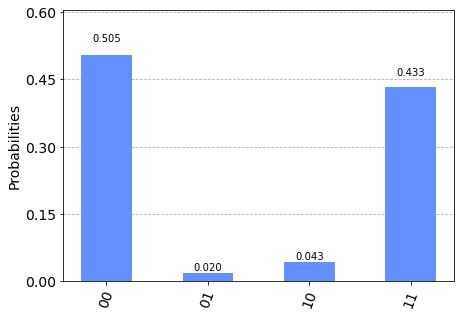

In [24]:
from qiskit.visualization import plot_histogram
    
plot_histogram(result.get_counts())

### Run Many Circuits

#### Before

In [ ]:
from qiskit.providers.ibmq.managed import IBMQJobManager

job_manager = IBMQJobManager()
job_set = job_manager.run(long_list_of_circuits, backend=backend)
results = job_set.results()

#### After

In [ ]:
job = backend.run(long_list_of_circuits) # returns IBMCompositeJob
result = job.result()

### Retrieve jobs

In [26]:
provider.jobs()

[<IBMCircuitJob('627c7cb57c918115bb9a73fe')>,
 <IBMCircuitJob('627c7c447c918158e79a73fd')>,
 <IBMCircuitJob('627c7b6a7c91811d5f9a73f7')>,
 <IBMCircuitJob('627574bb171ee83542258e41')>,
 <IBMCircuitJob('62756eb7911c8c972adef6e5')>,
 <IBMCircuitJob('627568b3d03f90b0766863ed')>,
 <IBMCircuitJob('627562848d1838a6e8a4f164')>,
 <IBMCircuitJob('627558568d18381a1da4f108')>,
 <IBMCircuitJob('6275542730321136b10fb39e')>,
 <IBMCircuitJob('62754655911c8ca604def5a5')>]

### Retrieve job

In [28]:
job = provider.job(job_id="627c7cb57c918115bb9a73fe")
print(job)

<IBMCircuitJob('627c7cb57c918115bb9a73fe')>


### Contributors

Huge thank you to the following contributors (in no particular order)!

Jessie Yu, Kevin Tian, Rathish Cholarajan, Daniel Kaulen, Matthew Treinish, Ali Javadiabhari, Blake Johnson, Ismael Faro, Jay Gambetta, Paul Nation, Luciano Bello, Paco Martin, Julien Gacon, Kevin Krsulich, Naoki Kanazawa, Zachary Schoenfeld, Matt Riedemann, Ismael Rozas Ramallal, Jorge Elihores Carballo Franquis, Fran Cabrera, Ryan Cocuzzo

### Questions